## Adult Data

** Import the libraries you usually use for data analysis.**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix,classification_report
from mpl_toolkits.mplot3d import Axes3D # 3d scatter plot

In [2]:
# parameters
n_seed = 111
n_centroids = 2
n_init = 10

In [3]:
df = pd.read_csv('./clean_data/adult_train.txt',index_col=False)
labels = df['income']
df = df.drop('income',axis=1)

In [4]:
#print(confusion_matrix(labels, kmeans.labels_))
#print(classification_report(labels, kmeans.labels_))

In [5]:
# normalize only continuous numeric columns
#a = df[['age','hr_per_week']]
#df[['age','hr_per_week']] = (a - a.mean()) / np.std(a)

# normalize everything such that categoricals are not affected
a = df
#df = (a - a.mean()) / np.std(a)
df = (a - a.min()) / (a.max() - a.min())

### Apply K Means

In [6]:
kmeans = KMeans(n_clusters=n_centroids, random_state=n_seed, n_init=n_init)
kmeans.fit(df)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=2, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=111, tol=0.0001, verbose=0)

In [7]:
print(confusion_matrix(labels,kmeans.labels_))
print(classification_report(labels,kmeans.labels_))

[[15763  6891]
 [ 1805  5703]]
             precision    recall  f1-score   support

          0       0.90      0.70      0.78     22654
          1       0.45      0.76      0.57      7508

avg / total       0.79      0.71      0.73     30162



### Apply EM

In [8]:
from sklearn.mixture import GaussianMixture

In [9]:
gm = GaussianMixture(n_components=n_centroids, random_state=n_seed, n_init=n_init)
gm.fit(df)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=2, n_init=10, precisions_init=None,
        random_state=111, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [10]:
gm_labels = gm.predict(df)

In [11]:
print(confusion_matrix(labels, gm_labels))
print(classification_report(labels, gm_labels))

[[ 6809 15845]
 [ 5682  1826]]
             precision    recall  f1-score   support

          0       0.55      0.30      0.39     22654
          1       0.10      0.24      0.15      7508

avg / total       0.44      0.29      0.33     30162



### Apply PCA to Normalized Data 

In [12]:
from sklearn.decomposition import PCA

In [13]:
#fig = plt.figure(figsize=(7,5))
#ax = fig.add_subplot(111, projection='3d')
#ax.scatter(pca3[:,0], pca3[:,1],pca3[:,2],c=df['income'],cmap='plasma')

In [14]:
n_features = len(df.columns)

## Try it on whole data

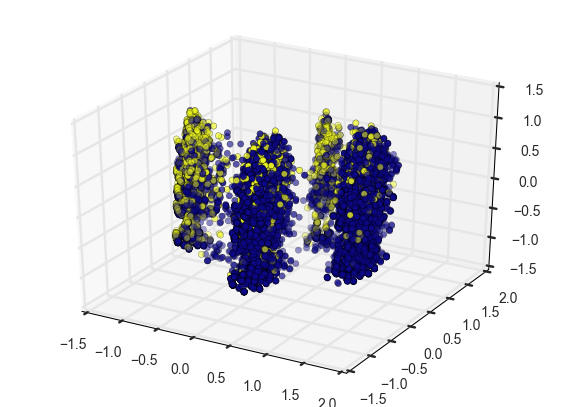

In [23]:
pca_all = PCA(n_components=0.99,  svd_solver = 'full')
pca_all.fit(df)
pca_n = pca_all.transform(df)
#pca_all.n_components_

fig = plt.figure(figsize=(7,5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pca_n[:,0], pca_n[:,1],pca_n[:,2],c=labels,cmap='plasma')


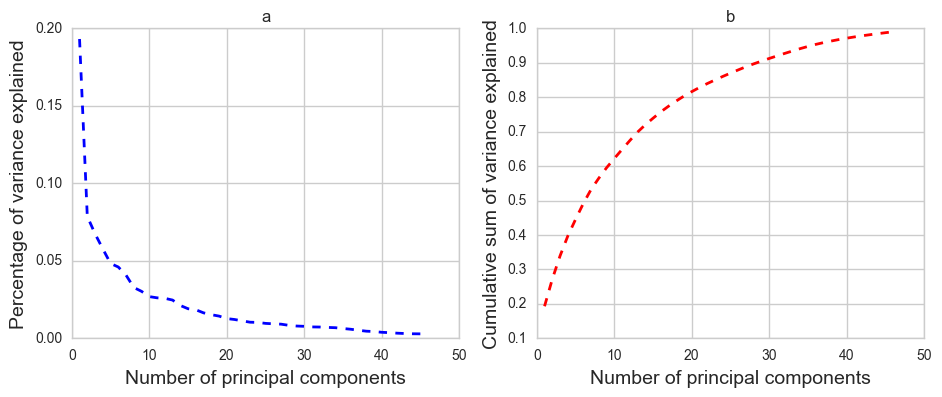

In [16]:
y = pca_all.explained_variance_ratio_
x = np.arange(len(y)) + 1

# plot pca
sns.set_style("whitegrid")
fig = plt.figure(figsize=(11,4))
sub1 = plt.subplot(121, title = 'a')
plt.xlabel('Number of principal components', fontsize = 14)
plt.ylabel('Percentage of variance explained', fontsize = 14)
plt.plot(x ,y, '--',lw=2., color='blue')

sub2 = plt.subplot(122, title = 'b')
plt.xlabel('Number of principal components', fontsize = 14)
plt.ylabel('Cumulative sum of variance explained', fontsize = 14)
plt.plot(x ,np.cumsum(y), '--',lw=2.0, color='red')

### Apply k-means to PCA output

In [17]:
kmeans.fit(pca_n)
print(confusion_matrix(labels,kmeans.labels_))
print(classification_report(labels,kmeans.labels_))

[[15764  6890]
 [ 1805  5703]]
             precision    recall  f1-score   support

          0       0.90      0.70      0.78     22654
          1       0.45      0.76      0.57      7508

avg / total       0.79      0.71      0.73     30162



### Apply EM to PCA output

In [18]:
gm.fit(pca_n)
gm_labels = gm.predict(pca_n)
print(confusion_matrix(labels, gm_labels))
print(classification_report(labels, gm_labels))

[[15876  6778]
 [ 1833  5675]]
             precision    recall  f1-score   support

          0       0.90      0.70      0.79     22654
          1       0.46      0.76      0.57      7508

avg / total       0.79      0.71      0.73     30162

